# Weekly S&P 500 Price Forecast with Tuned LSTM

This notebook implements a deep‐learning pipeline to **forecast next week’s S&P 500 close** on weekly bars using an LSTM network tuned via KerasTuner.

**Workflow:**
1. **Data Acquisition:** fetch daily S&P 500 OHLCV with backoff, resample to weekly.  
2. **Feature Engineering:** technical indicators + yield spread + trend strength.  
3. **Target:** log‐returns for stationarity.  
4. **Sequence Prep:** sliding windows of 20–30 weeks (tunable).  
5. **Hyperparameter Tuning:** search over window size, LSTM units & learning rate.  
6. **Train & Forecast:** best model predicts log‐returns; invert to prices.  
7. **Evaluate:** plot actual vs forecast and report metrics.



In [ ]:
!pip install keras-tuner

In [37]:
import time
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
def fetch_history(ticker, period="max", interval="1d", retries=5):
    for i in range(retries):
        try:
            df = yf.Ticker(ticker).history(period=period, interval=interval)
            return df[['Open','High','Low','Close','Volume']]
        except Exception as e:
            wait = 2**i
            print(f"Fetch error ({e}), retrying in {wait}s…")
            time.sleep(wait)
    raise RuntimeError(f"Failed to fetch {ticker}")

# 1) Download & resample
daily = fetch_history("^GSPC")
weekly = (daily
    .resample('W-FRI')
    .agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})
    .iloc[:-1]
)

In [45]:
# Technical features
delta  = weekly['Close'].diff()
gain   = delta.clip(lower=0)
loss   = -delta.clip(upper=0)
weekly['RSI_14'] = 100 - (100/(1 + gain.rolling(14).mean()/loss.rolling(14).mean()))

weekly['EMA_50']  = weekly['Close'].ewm(span=50, adjust=False).mean()
weekly['EMA_200'] = weekly['Close'].ewm(span=200,adjust=False).mean()
weekly['MA_Cross'] = (weekly['EMA_50']>weekly['EMA_200']).astype(int)

hl = weekly['High']-weekly['Low']
hp = (weekly['High']-weekly['Close'].shift()).abs()
lp = (weekly['Low'] -weekly['Close'].shift()).abs()
tr = pd.concat([hl,hp,lp],axis=1).max(axis=1)
weekly['ATR_14'] = tr.rolling(14).mean()

vwap = (weekly['Close']*weekly['Volume']).cumsum()/weekly['Volume'].cumsum()
weekly['VWAP_dev'] = weekly['Close']/vwap

weekly['Vol_Avg_4'] = weekly['Volume'].rolling(4).mean()
weekly['Vol_Spike']  = weekly['Volume']/weekly['Vol_Avg_4']

tnx = fetch_history("^TNX")['Close'].reindex(weekly.index,method='ffill')
fvx = fetch_history("^FVX")['Close'].reindex(weekly.index,method='ffill')
weekly['Yield_Spread'] = (tnx-fvx)/10

weekly['Trend_20'] = (weekly['Close'].diff()>0).rolling(20).sum()

# Log-return target
weekly['LogR'] = np.log(weekly['Close']/weekly['Close'].shift(1))
weekly.dropna(inplace=True)

# --- your existing indicators above ---

# 8) **Add 1-week percent change** so the LSTM sees the actual move
weekly['Return_1w'] = weekly['Close'].pct_change()

# 9) **Add the raw (standardized) close level** so it can learn price‐level effects
weekly['Close_scaled'] = StandardScaler().fit_transform(weekly[['Close']])

# Final feature list
feature_cols = [
    'RSI_14','MA_Cross','ATR_14','VWAP_dev',
    'Vol_Spike','Yield_Spread','Trend_20',
    'Return_1w','Close_scaled'
]

# Drop any rows missing these
weekly.dropna(subset=feature_cols + ['LogR'], inplace=True)

In [46]:
# scale full dataset
X_all = StandardScaler().fit_transform(weekly[feature_cols])
y_all = weekly['LogR'].values

N         = len(X_all)
test_size = min(int(0.2 * N), 52)

def build_model(hp):
    window = hp.Int("window", 10, 30, step=5)
    u1     = hp.Int("units1", 32,128, step=32)
    u2     = hp.Int("units2", 16,64,  step=16)
    lr     = hp.Float("lr", 1e-4,1e-2, sampling="log")
    m = Sequential([
        LSTM(u1, return_sequences=True, input_shape=(window, len(feature_cols))),
        Dropout(0.2),
        LSTM(u2),
        Dropout(0.2),
        Dense(1)
    ])
    m.compile(optimizer=Adam(lr), loss="mse")
    return m

tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=8,
    executions_per_trial=2,
    directory="tuner_dir",
    project_name="sp500_lstm"
)

# determine max window for dummy data
hp_space   = tuner.oracle.hyperparameters.space
max_window = next(hp for hp in hp_space if hp.name=="window").max_value

# supply enough dummy samples so validation_split works
n_dummy = 10
dummy_X = np.zeros((n_dummy, max_window, len(feature_cols)))
dummy_y = np.zeros((n_dummy,))

# run a single-epoch search
tuner.search(dummy_X, dummy_y, epochs=1, validation_split=0.1)

Reloading Tuner from tuner_dir/sp500_lstm/tuner0.json


In [47]:
# Cell 6 — Train Best Model & Forecast

# 1) Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
window  = best_hp.get("window")

# 2) Build sequences using the chosen window size
X_seq, y_seq = [], []
for i in range(window, N):
    X_seq.append(X_all[i-window:i])
    y_seq.append(y_all[i])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# 3) Split into training and hold-out sets
X_tr, y_tr = X_seq[:-test_size], y_seq[:-test_size]
X_te, y_te = X_seq[-test_size:], y_seq[-test_size:]

# 4) Rebuild and compile the model with the best hyperparameters
model = build_model(best_hp)
es    = EarlyStopping(patience=10, restore_best_weights=True)

# 5) Train the model
model.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)

# 6) Forecast log-returns and invert to price predictions
y_pred_log = model.predict(X_te).flatten()
last_price  = weekly['Close'].iloc[-test_size-1]
price_pred  = last_price * np.exp(np.cumsum(y_pred_log))
price_true  = weekly['Close'].iloc[-test_size:].values
dates       = weekly.index[-test_size:]

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0151 - val_loss: 0.0034
Epoch 2/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0069 - val_loss: 0.0013
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0042 - val_loss: 8.2577e-04
Epoch 4/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 5/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 6/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0019 - val_loss: 6.7008e-04
Epoch 7/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0017 - val_loss: 6.3417e-04
Epoch 8/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0015 - val_loss: 6.6658e-04
Epoch 9/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0013 - val_loss: 6.1961e-04
Epoch 10/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0012 - val_loss: 5.9708e-04
Epoch 11/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0011 - val_loss: 5.9487e-04
Epoch 12/100
2

LogR MSE: 0.0005698079465833743
LogR MAE: 0.017252752393881104
LogR R²: 0.013068131941003092
Price MSE: 205113.56161767355
Price MAE: 400.3484979241699
Price R²: -1.553419359667548


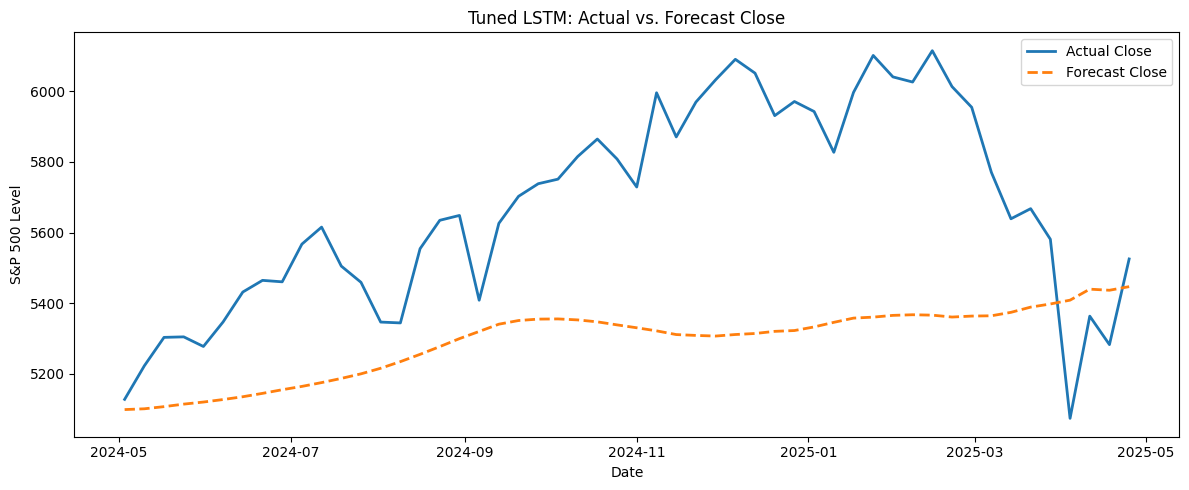

In [48]:
# Metrics in log-return space
print("LogR MSE:", mean_squared_error(y_te, y_pred_log))
print("LogR MAE:", mean_absolute_error(y_te, y_pred_log))
print("LogR R²:",  r2_score(y_te, y_pred_log))

# Metrics in price space
print("Price MSE:", mean_squared_error(price_true, price_pred))
print("Price MAE:", mean_absolute_error(price_true, price_pred))
print("Price R²:",  r2_score(price_true, price_pred))

plt.figure(figsize=(12,5))
plt.plot(dates, price_true, label="Actual Close", linewidth=2)
plt.plot(dates, price_pred, '--', label="Forecast Close", linewidth=2)
plt.title("Tuned LSTM: Actual vs. Forecast Close")
plt.xlabel("Date"); plt.ylabel("S&P 500 Level")
plt.legend(); plt.tight_layout(); plt.show()